In [212]:
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from skimage import measure
from midiutil.MidiFile import MIDIFile
import pygame

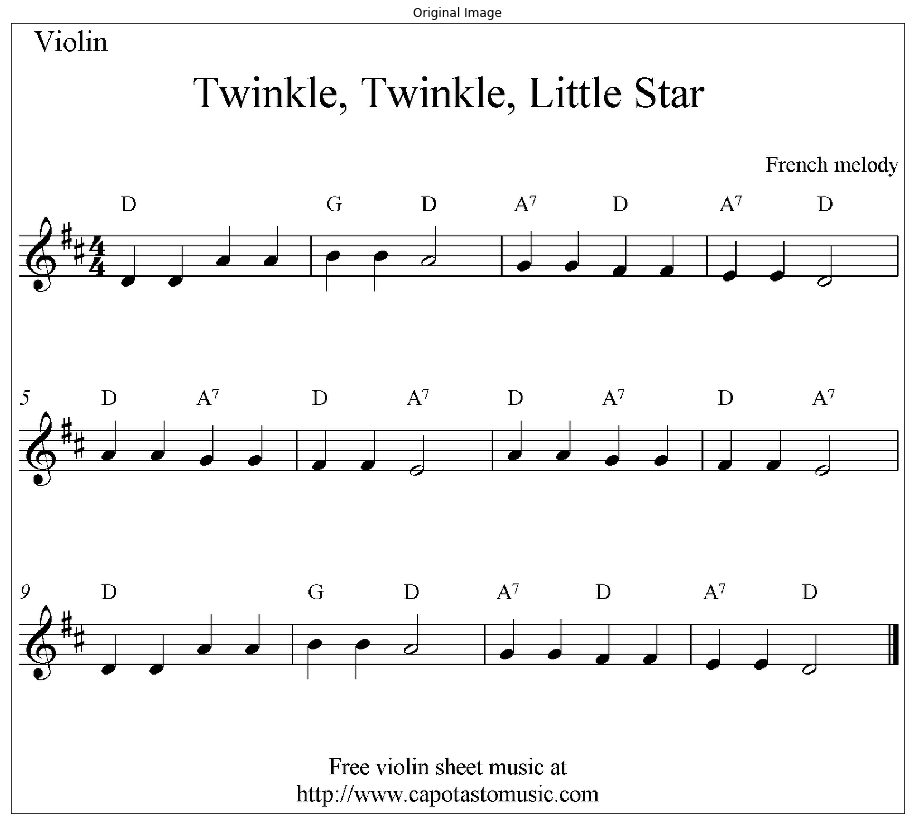

In [213]:
img = cv2.imread('Images/TTLS.png', 0)

plt.figure(figsize=(16,16))
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Original Image')
plt.show()

In [214]:
blur = cv2.GaussianBlur(img,(5,5),0)
thresh, img_bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

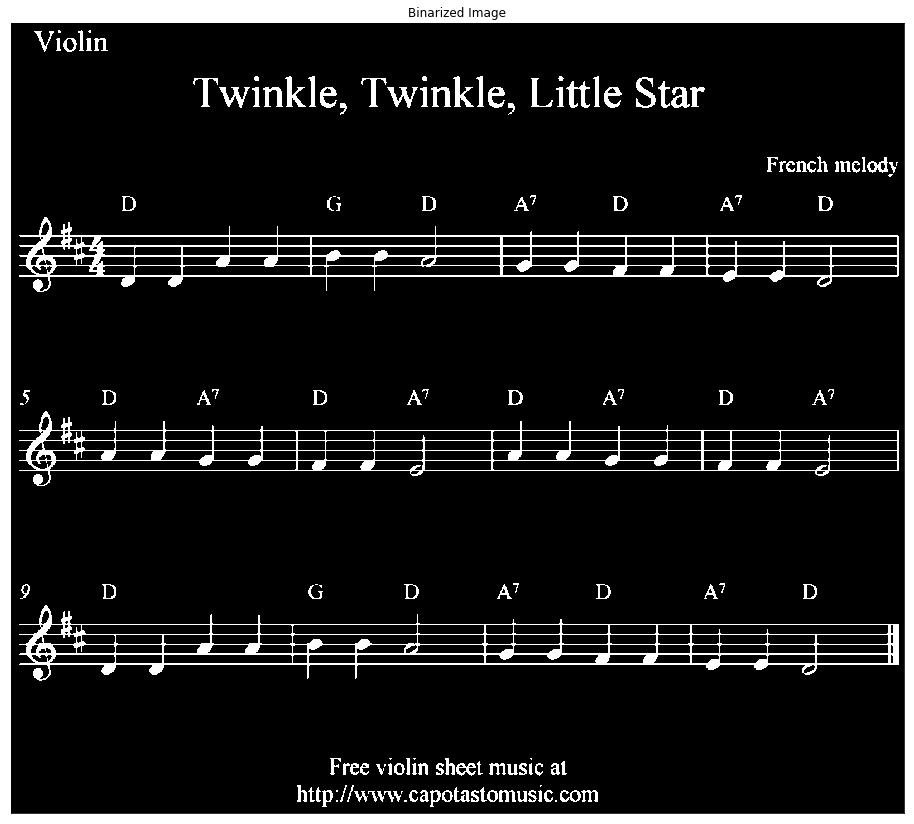

In [215]:
plt.figure(figsize=(16,16))
plt.imshow(img_bw, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Binarized Image')
plt.show()

In [216]:
def horizontal_projection(img):
    h,w = img.shape
    row_sum = []
    for i in range(h):
        row_sum.append(sum(img[i, 0:w]))
    return row_sum

In [217]:
def vertical_projection(img):
    h,w = img.shape
    col_sum = []
    for i in range(w):
        col_sum.append(sum(img[0:h, i]))
    return col_sum

In [218]:
row_sum = horizontal_projection(img_bw)
col_sum = vertical_projection(img_bw)

In [219]:
h,w = img.shape

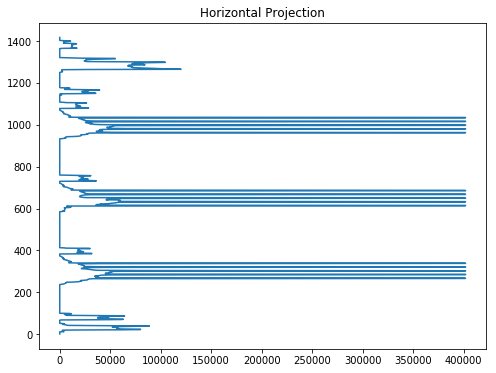

In [220]:
plt.figure(figsize=(8,6))
plt.plot(row_sum, range(h,0,-1))
plt.title('Horizontal Projection')
plt.show()

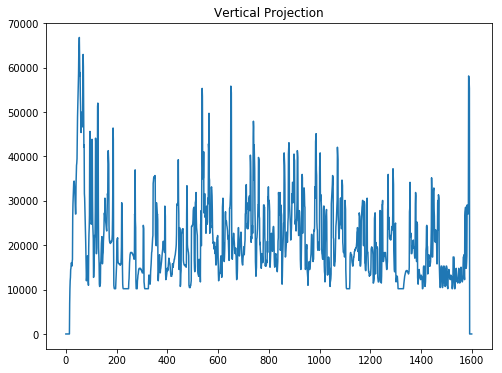

In [221]:
plt.figure(figsize=(8,6))
plt.plot(range(w), col_sum)
plt.title('Vertical Projection')
plt.show()

In [222]:
hp_max = max(row_sum)
for i in range(len(row_sum)):
    if row_sum[i] < 0.9*hp_max:
        row_sum[i] = 0

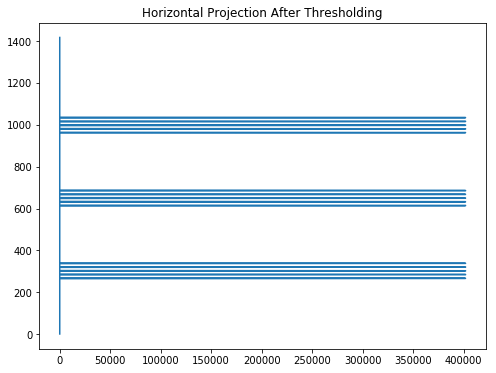

In [223]:
plt.figure(figsize=(8,6))
plt.plot(row_sum, range(h,0,-1))
plt.title('Horizontal Projection After Thresholding')
plt.show()

In [224]:
staff_lines = []
for i in range(len(row_sum)):
    if row_sum[i]>0:
        staff_lines.append(i)
len(staff_lines)

40

In [225]:
grand_stave_start = []
grand_stave_end = []

grand_stave_start.append(staff_lines[0])
for i in range(len(staff_lines)-1):
    if staff_lines[i+1]-staff_lines[i]>20:
        grand_stave_end.append(staff_lines[i])
        grand_stave_start.append(staff_lines[i+1])
grand_stave_end.append(staff_lines[i+1])
        
print(grand_stave_start)
print(grand_stave_end)

[382, 730, 1078]
[455, 804, 1151]


In [226]:
grand_staves = []
for i in range(len(grand_stave_start)):
    grand_staves.append(img_bw[grand_stave_start[i]-40:grand_stave_end[i]+40])   

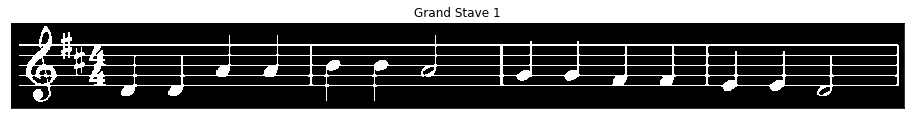

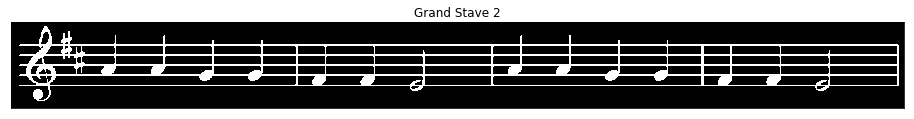

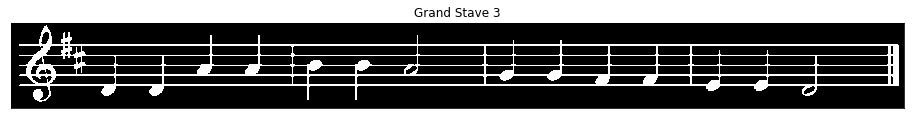

In [227]:
count=0
for i in grand_staves:
    count+=1
    plt.figure(figsize=(16,16))
    plt.imshow(i, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Grand Stave {}'.format(count))
    plt.show()

In [228]:
bar_dict = {}
bar_height_list = []
count=0

for i in grand_staves:
    print(i.shape)
    count+=1
#     plt.figure(figsize=(16,16))
#     plt.imshow(i, cmap = 'gray')
#     plt.xticks([]), plt.yticks([])
#     plt.title('Grand Stave {}'.format(count))
    
    col_sum = vertical_projection(i)
    vp_max = max(col_sum)
    bar_height_list.append(vp_max)
    bar_lines = []
    
    for j in range(len(col_sum)):
        if col_sum[j] < 0.9*vp_max:
            col_sum[j] = 0
        else:
            bar_lines.append(j)
    
    bar_dict[count-1] = bar_lines
    
#     plt.figure(figsize=(16,4))
#     plt.plot(range(w), col_sum)
#     plt.xticks([]), plt.yticks([])
#     plt.title('Vertical Projection for Grand Stave {}'.format(count))
#     plt.show()
bar_height_avg = int(np.mean(bar_height_list)/255)
print(bar_height_avg)
print(bar_dict)

(153, 1600)
(154, 1600)
(153, 1600)
81
{0: [51, 52, 53, 54, 68, 69, 536, 537, 538, 877, 878, 879, 880, 1246, 1247, 1248, 1468, 1587, 1588, 1589, 1590], 1: [51, 52, 53, 54, 56, 68, 69, 510, 511, 512, 513, 860, 861, 862, 863, 1237, 1238, 1239, 1240, 1587, 1588], 2: [51, 52, 53, 54, 68, 69]}


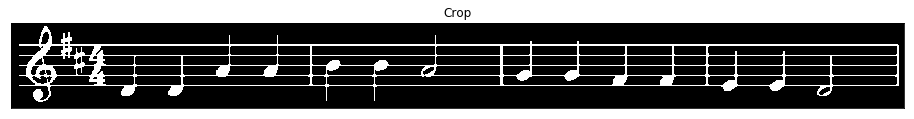

In [229]:
crop = img_bw[grand_stave_start[0]-40:grand_stave_end[0]+40]
crop_copy = crop.copy()
plt.figure(figsize=(16,9))
plt.imshow(crop, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Crop')
plt.show()

In [230]:
staff_lines_avg = []
temp = []

for i in range(len(staff_lines)-1):
    if staff_lines[i+1]-staff_lines[i]<2:
        temp.append(staff_lines[i])
        temp.append(staff_lines[i+1])
    else:
        staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
        temp = []

staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
len(staff_lines_avg)

15

In [231]:
# segmented_image = img_bw.copy()
# for i in staff_lines:
#     for j in range(w):
#         if sum(segmented_image[i-5:i+5, j])<1500:
#             segmented_image[i,j]=0

In [232]:
# plt.figure(figsize=(16,9))
# plt.imshow(segmented_image, cmap = 'gray')
# plt.xticks([]), plt.yticks([])
# plt.title('Line Removal')
# plt.show()

In [233]:
# from skimage import measure

# counter = 0

# segmented_image_transpose = segmented_image.transpose()
# labels = measure.label(segmented_image_transpose, neighbors=8, background=0)

# for label in np.unique(labels):
#     if label == 0:
#         continue

#     labelMask = np.zeros(segmented_image_transpose.shape, dtype="uint8")
#     labelMask[labels == label] = 255
    
#     note = labelMask.transpose()
#     numPixels = cv2.countNonZero(note)

#     if numPixels > 25:
#         x,y,w,h = cv2.boundingRect(note)
        
#         filename = 'Output/'+str(counter)+'.jpg'
#         crop_img = segmented_image[y:y+h, x:x+w]
#         cv2.imwrite(filename, crop_img)
#         counter += 1
        
#         cv2.rectangle(segmented_image,(x-5,y-5),(x+w+5,y+h+5),(255,255,255),2)
        
# plt.figure(figsize=(16,16))
# plt.imshow(segmented_image, cmap = 'gray')
# plt.xticks([]), plt.yticks([])
# plt.title('Detected Notes')
# plt.show()

In [234]:
def crop_notes(img, img_copy, counter=0):
    img_height, img_width = img.shape
    note_point_list = []

    image_transpose = img.transpose()
    labels = measure.label(image_transpose, neighbors=8, background=0)

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(image_transpose.shape, dtype="uint8")
        labelMask[labels == label] = 255

        note = labelMask.transpose()
        numPixels = cv2.countNonZero(note)

        if numPixels > 25:
            row_sum = horizontal_projection(note)
            hp_max = max(row_sum)
            for i in range(len(row_sum)):
                if row_sum[i] < 0.5*hp_max:
                    row_sum[i] = 0

            note_point = [i for i, x in enumerate(row_sum) if x][-1]
            note_point_list.append(note_point)

            x,y,w,h = cv2.boundingRect(note)
            filename = 'Output/'+str(counter)+'.jpg'
            # crop_img = img_copy[y:y+bar_height_avg, x:x+w]
            crop_img = img_copy[0:img_height, x:x+w]
            cv2.imwrite(filename, crop_img)
            counter += 1
            cv2.rectangle(img,(x-5,y-5),(x+w+5,y+h+5),(255,255,255),2)

    plt.figure(figsize=(16,16))
    plt.imshow(img, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Detected Notes')
    plt.show()
    
    return counter, note_point_list

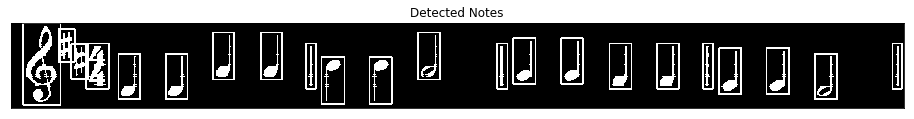

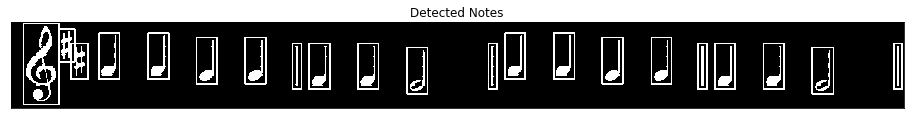

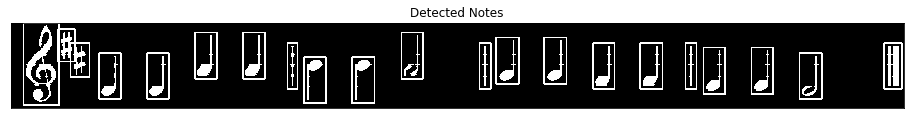

In [235]:
counter = 0
note_point_dict = {}
last_staff_line_dict = {}
key_count = 0
for k in grand_staves:
    img_copy = k.copy()
    
    row_sum = horizontal_projection(k)
    hp_max = max(row_sum)

    for i in range(len(row_sum)):
        if row_sum[i] < 0.9*hp_max:
            row_sum[i] = 0

    staff_lines = []
    for i in range(len(row_sum)):
        if row_sum[i]>0:
            staff_lines.append(i)

    for i in staff_lines:
        for j in range(w): 
            if sum(k[i-5:i+5, j])<1500:
                k[i,j]=0
    
#     col_sum = vertical_projection(k)
#     vp_max = max(col_sum)

#     for i in range(len(col_sum)):
#         if col_sum[i] < 0.9*vp_max:
#             col_sum[i] = 0

#     for i in range(w):
#         if col_sum[i] != 0:
#             k[:,i] = 0
    
    staff_lines_avg = []
    temp = []

    for i in range(len(staff_lines)-1):
        if staff_lines[i+1]-staff_lines[i]<2:
            temp.append(staff_lines[i])
            temp.append(staff_lines[i+1])
        else:
            staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
            temp = []

    staff_lines_avg.append(int(round(np.mean(list(set(temp))))))
    last_staff_line_dict[key_count] = staff_lines_avg[-1]

    counter, note_point_list = crop_notes(k, img_copy, counter)
    note_point_dict[key_count] = note_point_list
    key_count+=1

In [236]:
# for i in range(counter):
#     filename = 'Output/'+str(i)+'.jpg'
#     note_img = cv2.imread(filename, 0)
#     resized_img = cv2.resize(note_img, (20,20))
#     X = np.reshape(resized_img, (1, 400))

In [237]:
# img = cv2.imread('Test/14.jpg', 0)
# # template = cv2.imread('Templates/quarter_note.png', 0)
# template = cv2.imread('Templates/b.png', 0)
# print(img.shape)
# print(template.shape)
# template = cv2.resize(template, (20,20))
# template = ~template

# h,w = template.shape
# img2 = img.copy()

# result = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
# min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
# print(max_val)
# top_left = max_loc
# bottom_right = (top_left[0] + h, top_left[1] + w)
# cv2.rectangle(img,top_left, bottom_right, 128, 5)

# plt.subplot(121),plt.imshow(result,cmap = 'gray')
# plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(img,cmap = 'gray')
# plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
# plt.show()

In [241]:
last_staff_line_dict

{0: 112, 1: 113, 2: 112}

In [242]:
note_point_dict

{0: [111,
  59,
  83,
  111,
  130,
  130,
  96,
  96,
  111,
  85,
  85,
  96,
  111,
  102,
  102,
  113,
  113,
  111,
  120,
  120,
  130,
  112],
 1: [111,
  58,
  82,
  96,
  96,
  103,
  103,
  114,
  114,
  114,
  122,
  114,
  96,
  96,
  103,
  103,
  114,
  114,
  114,
  122,
  114],
 2: [132,
  60,
  80,
  129,
  129,
  95,
  95,
  110,
  85,
  84,
  94,
  96,
  102,
  102,
  113,
  113,
  96,
  120,
  120,
  129,
  113]}


 0
Max Score =  0.9348577260971069
treble_clef_4


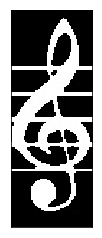


 1
===Image smaller than Template===
None


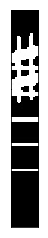


 2
Max Score =  0.8575835824012756
sharp


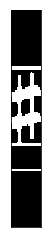


 3
Max Score =  0.9334771633148193
time_4


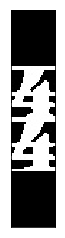


 4
Max Score =  0.9320333003997803
quarter_note


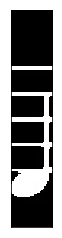


 5
Max Score =  0.9334552884101868
quarter_note


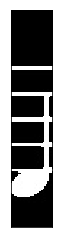


 6
Max Score =  0.9174952507019043
quarter_note


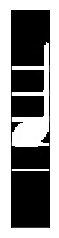


 7
Max Score =  0.9174702763557434
quarter_note


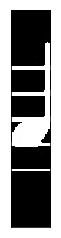


 8
===Image smaller than Template===
None


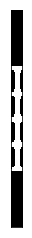


 9
Max Score =  0.9508547186851501
quarter_note


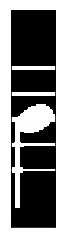


 10
Max Score =  0.9493931531906128
quarter_note


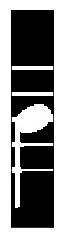


 11
Max Score =  0.7428690791130066
half_note


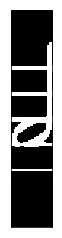


 12
===Image smaller than Template===
None


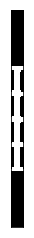


 13
Max Score =  0.9520732164382935
quarter_note


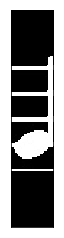


 14
Max Score =  0.955325186252594
quarter_note


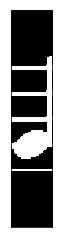


 15
Max Score =  0.9105778932571411
quarter_note


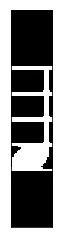


 16
Max Score =  0.910616397857666
quarter_note


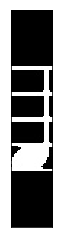


 17
===Image smaller than Template===
None


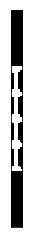


 18
Max Score =  0.9520565271377563
quarter_note


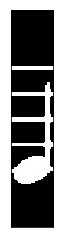


 19
Max Score =  0.9537762999534607
quarter_note


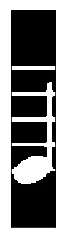


 20
Max Score =  0.7466428279876709
half_note


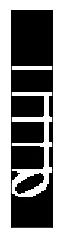


 21
===Image smaller than Template===
None



 22
Max Score =  0.928290843963623
treble_clef_4


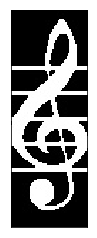


 23
===Image smaller than Template===
None


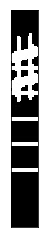


 24
Max Score =  0.8603799939155579
sharp


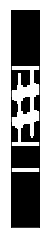


 25
Max Score =  0.9098719954490662
quarter_note


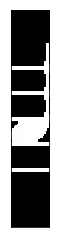


 26
Max Score =  0.909466028213501
quarter_note


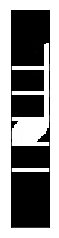


 27
Max Score =  0.9490225911140442
quarter_note


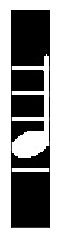


 28
Max Score =  0.9487415552139282
quarter_note


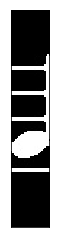


 29
===Image smaller than Template===
None



 30
Max Score =  0.9112771153450012
quarter_note


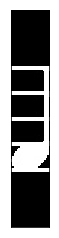


 31
Max Score =  0.9108981490135193
quarter_note


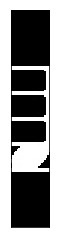


 32
Max Score =  0.7620519995689392
half_note


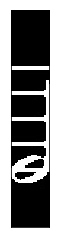


 33
===Image smaller than Template===
None



 34
Max Score =  0.9073783159255981
quarter_note


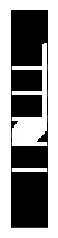


 35
Max Score =  0.9108694195747375
quarter_note


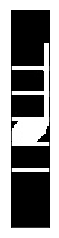


 36
Max Score =  0.9487415552139282
quarter_note


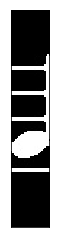


 37
Max Score =  0.9470610022544861
quarter_note


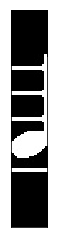


 38
===Image smaller than Template===
None



 39
Max Score =  0.9112738370895386
quarter_note


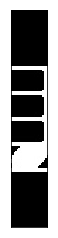


 40
Max Score =  0.9121228456497192
quarter_note


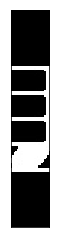


 41
Max Score =  0.7665539383888245
quarter_note


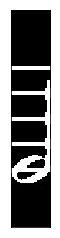


 42
===Image smaller than Template===
None



 43
Max Score =  0.9347829222679138
treble_clef_4


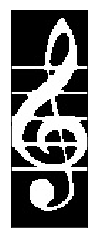


 44
Max Score =  0.833462119102478
quarter_note


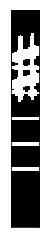


 45
Max Score =  0.8559077382087708
sharp


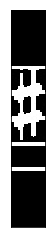


 46
Max Score =  0.9280412793159485
quarter_note


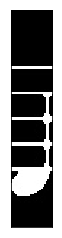


 47
Max Score =  0.9280421137809753
quarter_note


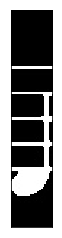


 48
Max Score =  0.9134836792945862
quarter_note


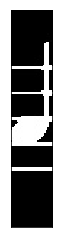


 49
Max Score =  0.9134988188743591
quarter_note


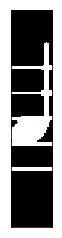


 50
===Image smaller than Template===
None


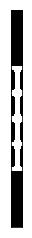


 51
Max Score =  0.9551988840103149
quarter_note


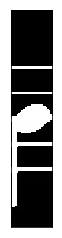


 52
Max Score =  0.9537282586097717
quarter_note


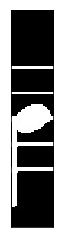


 53
Max Score =  0.732494056224823
half_note


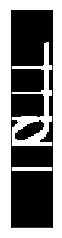


 54
===Image smaller than Template===
None


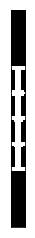


 55
Max Score =  0.9508140683174133
quarter_note


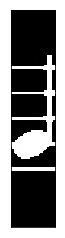


 56
Max Score =  0.9522202014923096
quarter_note


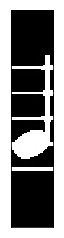


 57
Max Score =  0.909428596496582
quarter_note


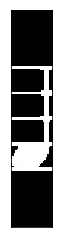


 58
Max Score =  0.9120287895202637
quarter_note


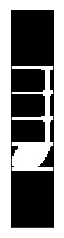


 59
===Image smaller than Template===
None


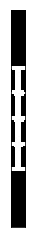


 60
Max Score =  0.9505702257156372
quarter_note


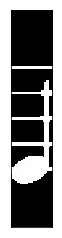


 61
Max Score =  0.950556755065918
quarter_note


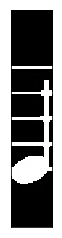


 62
Max Score =  0.7573844194412231
half_note


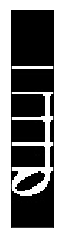


 63
Max Score =  0.7712035179138184
sharp


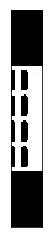

In [238]:
# template_names = ['half_note', 'quarter_note', 'whole_note', 'bass_clef', 'treble_clef', 'treble_clef_2', 'treble_clef_3', 'treble_clef_4']
template_names = ['half_note', 'quarter_note', 'whole_note', 'treble_clef_4', 'bass_clef_2', 'time_4', 'sharp']
template_matching_result = []

for i in range(64):
    filename = 'Output/'+str(i)+'.jpg'
    img = cv2.imread(filename, 0)
    max_score = -999
    
    for t in template_names:
        template_filename = 'Templates/'+str(t)+'.png'
        template = cv2.imread(template_filename, 0)
        template = cv2.resize(template, (20,20))
        
        h,w = template.shape
        img_h,img_w = img.shape
        if img_h<h or img_w<w:
            continue
        
        result = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
#         result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
#         print(max_val)
        if max_val>max_score:
            max_score = max_val
            best_t = t
        top_left = max_loc
        bottom_right = (top_left[0] + h, top_left[1] + w)
    print("\n",i)
    if max_score == -999:
        print("===Image smaller than Template===")
    else:
        print("Max Score = ", max_score)
    print(best_t)
    best_t = None
    plt.imshow(img, cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.show()


 0
Max Score =  0.9348577260971069
treble_clef_4


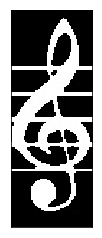


 1
Image smaller than template

 2
Max Score =  0.8575835824012756
sharp


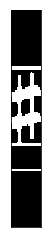


 3
Max Score =  0.9334771633148193
time_4


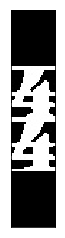


 4
Max Score =  0.9320333003997803
quarter_note


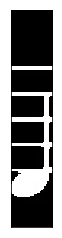


 5
Max Score =  0.9334552884101868
quarter_note


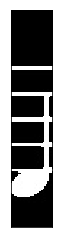


 6
Max Score =  0.9174952507019043
quarter_note


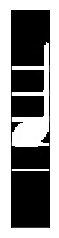


 7
Max Score =  0.9174702763557434
quarter_note


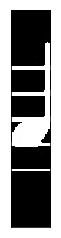


 8
Image smaller than template

 9
Max Score =  0.9508547186851501
quarter_note


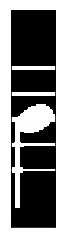


 10
Max Score =  0.9493931531906128
quarter_note


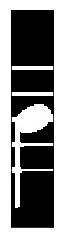


 11
Max Score =  0.7428690791130066
half_note


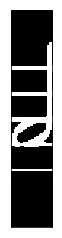


 12
Image smaller than template

 13
Max Score =  0.9520732164382935
quarter_note


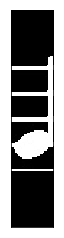


 14
Max Score =  0.955325186252594
quarter_note


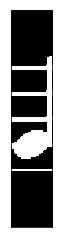


 15
Max Score =  0.9105778932571411
quarter_note


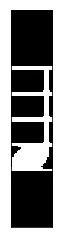


 16
Max Score =  0.910616397857666
quarter_note


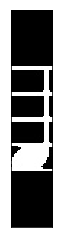


 17
Image smaller than template

 18
Max Score =  0.9520565271377563
quarter_note


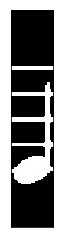


 19
Max Score =  0.9537762999534607
quarter_note


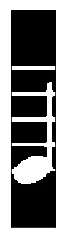


 20
Max Score =  0.7466428279876709
half_note


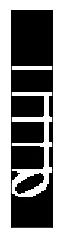


 21
Image smaller than template

 22
Max Score =  0.928290843963623
treble_clef_4


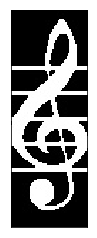


 23
Image smaller than template

 24
Max Score =  0.8603799939155579
sharp


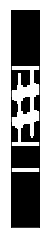


 25
Max Score =  0.9098719954490662
quarter_note


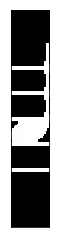


 26
Max Score =  0.909466028213501
quarter_note


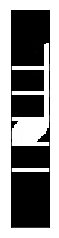


 27
Max Score =  0.9490225911140442
quarter_note


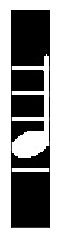


 28
Max Score =  0.9487415552139282
quarter_note


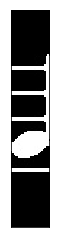


 29
Image smaller than template

 30
Max Score =  0.9112771153450012
quarter_note


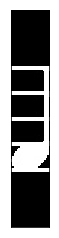


 31
Max Score =  0.9108981490135193
quarter_note


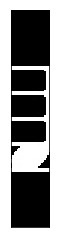


 32
Max Score =  0.7620519995689392
half_note


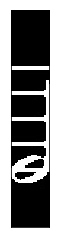


 33
Image smaller than template

 34
Max Score =  0.9073783159255981
quarter_note


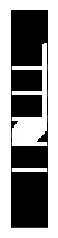


 35
Max Score =  0.9108694195747375
quarter_note


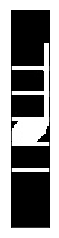


 36
Max Score =  0.9487415552139282
quarter_note


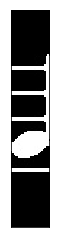


 37
Max Score =  0.9470610022544861
quarter_note


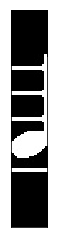


 38
Image smaller than template

 39
Max Score =  0.9112738370895386
quarter_note


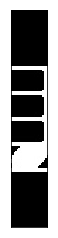


 40
Max Score =  0.9121228456497192
quarter_note


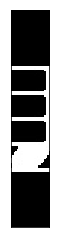


 41
Max Score =  0.7665539383888245
quarter_note


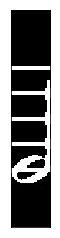


 42
Image smaller than template

 43
Max Score =  0.9347829222679138
treble_clef_4


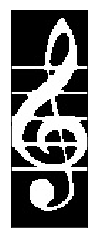


 44
Max Score =  0.833462119102478
quarter_note


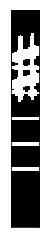


 45
Max Score =  0.8559077382087708
sharp


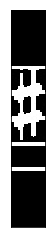


 46
Max Score =  0.9280412793159485
quarter_note


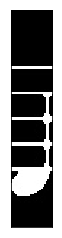


 47
Max Score =  0.9280421137809753
quarter_note


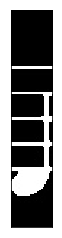


 48
Max Score =  0.9134836792945862
quarter_note


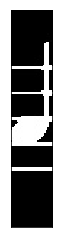


 49
Max Score =  0.9134988188743591
quarter_note


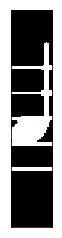


 50
Image smaller than template

 51
Max Score =  0.9551988840103149
quarter_note


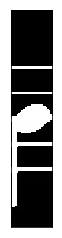


 52
Max Score =  0.9537282586097717
quarter_note


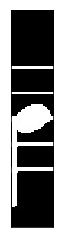


 53
Max Score =  0.732494056224823
half_note


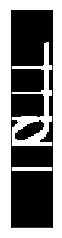


 54
Image smaller than template

 55
Max Score =  0.9508140683174133
quarter_note


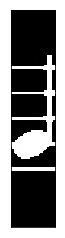


 56
Max Score =  0.9522202014923096
quarter_note


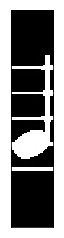


 57
Max Score =  0.909428596496582
quarter_note


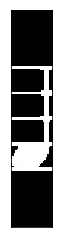


 58
Max Score =  0.9120287895202637
quarter_note


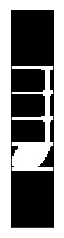


 59
Image smaller than template

 60
Max Score =  0.9505702257156372
quarter_note


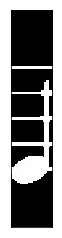


 61
Max Score =  0.950556755065918
quarter_note


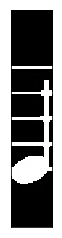


 62
Max Score =  0.7573844194412231
half_note


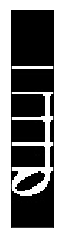


 63
Max Score =  0.7712035179138184
sharp


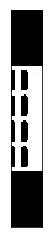

In [283]:
template_names = ['half_note', 'quarter_note', 'whole_note', 'treble_clef_4', 'bass_clef_2', 'time_4', 'sharp']
template_matching_result = []
mapping_dict = {-18: 'D', -9: 'E', 0: 'F', 9: 'G', 18: 'A', 27: 'B', 36: 'C', 45: 'D', 54: 'E', 63: 'F', 72: 'G'}
recognized_notes = []
time_gaps = []

img_counter=0
for key, value in note_point_dict.items():
    for i in range(len(value)):
        
        filename = 'Output/'+str(img_counter)+'.jpg'
        img = cv2.imread(filename, 0)
        max_score = -999

        for t in template_names:
            template_filename = 'Templates/'+str(t)+'.png'
            template = cv2.imread(template_filename, 0)
            template = cv2.resize(template, (20,20))

            h,w = template.shape
            img_h,img_w = img.shape
            if img_h<h or img_w<w:
                continue

            result = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

            if max_val>max_score:
                max_score = max_val
                best_match = t
            top_left = max_loc
            bottom_right = (top_left[0] + h, top_left[1] + w)
            
        min_distance = 9999
        if best_match != None and 'note' in best_match:
#             nearest_note = None
            distance = last_staff_line_dict[key] - note_point_dict[key][i]
            for k,v in mapping_dict.items():
                difference = abs(distance-k)
                if difference < min_distance:
                    nearest_note = mapping_dict[k]
                    min_distance = difference
            recognized_notes.append(nearest_note)
        
            if 'quarter' in best_match:
                time_gaps.append(1)
            elif 'half' in best_match:
                time_gaps.append(2)
            else:
                time_gaps.append(4)

        print("\n", img_counter)
        if max_score != -999:
            print("Max Score = ", max_score)
            print(best_match)
            template_matching_result.append(best_match)
            best_match = None
            plt.imshow(img, cmap = 'gray')
            plt.xticks([]), plt.yticks([])
            plt.show()
        else:
            print("Image smaller than template")
#             template_matching_result.append(best_match)
        
        img_counter+=1

In [284]:
sharp_sequence = 'F-C-G-D-A-E-B'
sharp_counter = template_matching_result.count('sharp')
total_sharp_count = int(round(sharp_counter/len(grand_staves)))

for i in range(total_sharp_count):
    replacement = sharp_sequence.split('-')[i]
    
    recognized_notes = [note.replace(replacement, replacement+'#') for note in recognized_notes]

['D',
 'D',
 'A',
 'A',
 'B',
 'B',
 'A',
 'G',
 'G',
 'F#',
 'F#',
 'E',
 'E',
 'D',
 'A',
 'A',
 'G',
 'G',
 'F#',
 'F#',
 'E',
 'A',
 'A',
 'G',
 'G',
 'F#',
 'F#',
 'E',
 'E',
 'D',
 'D',
 'A',
 'A',
 'B',
 'B',
 'A',
 'G',
 'G',
 'F#',
 'F#',
 'E',
 'E',
 'D']

In [285]:
midi_note_codes = []
midi_mapping_dict = {'C': 60, 'C#': 61, 'D': 62, 'D#': 63, 'E': 64, 'F': 65, 'F#': 66, 'G': 67, 'G#': 68, 'A': 69, 'A#': 70, 'B': 71}

for note in recognized_notes:
    midi_note_codes.append(midi_mapping_dict[note])

In [292]:
track    = 0
channel  = 0
time     = 0
duration = 1
tempo    = 100
volume   = 127

MyMIDI = MIDIFile(1)
MyMIDI.addTempo(track, time, tempo)

for counter in range(len(midi_note_codes)):
    MyMIDI.addNote(track, channel, midi_note_codes[counter], time, time_gaps[counter], volume)
    time = time + time_gaps[counter]

with open("Audio/ttls.midi", "wb") as output_file:
    MyMIDI.writeFile(output_file)

In [293]:
sample_rate = 44100
channels = 2
buffer = 1024
bitsize = -16
pygame.mixer.init(sample_rate, bitsize, channels, buffer)
pygame.mixer.music.set_volume(1.0)

def play_music(music_file):

    try:
        pygame.mixer.music.load(music_file)

    except pygame.error:
        print ("Error playing %s! (%s)" % (music_file, pygame.get_error()))
        return

    pygame.mixer.music.play()

In [294]:
play_music('Audio/ttls.midi')